In [1]:
import pandas as pd
import numpy as np
import unicodedata
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [3]:
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from textblob import TextBlob, Word

In [ ]:
pip install wordcloud

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [9]:
import nltk
# Force clean re-download of punkt, stopwords, wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For lemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...


True

In [ ]:
import nltk

# Remove cache (optional but good for safety)
nltk.data.path.append("C:/Users/brajagopal/AppData/Roaming/nltk_data")

# Force re-download of punkt
nltk.download('punkt', download_dir="C:/Users/brajagopal/AppData/Roaming/nltk_data")


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [5]:
# Load dataset
df = pd.read_csv("Twitter_Omicron_data_1.csv")

# View initial rows
print(" Sample Rows:")
print(df.head(), "\n")

# Shape and column details
print(" Dataset Shape:", df.shape)
print(" Column Names:", df.columns.tolist())

# Null check
print("\n Missing Values:")
print(df.isnull().sum())

# Info check
print("\nℹ Data Info:")
print(df.info())

# ============================
#  Sample Preprocessing Preview
# ============================

# Initial basic cleaning using BeautifulSoup and Unicode
def basic_clean(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Normalize unicode characters
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    
    return text

# Apply to a sample
sample_raw = df['tweets'].iloc[0]
sample_clean = basic_clean(sample_raw)

print("\n Raw Tweet:")
print(sample_raw)

print("\n After Basic Cleaning (HTML + Unicode):")
print(sample_clean)


🔍 Sample Rows:
                                              tweets  likes  \
0  6 big questions about new Omicron-targeting bo...      0   
1               I'm confused https://t.co/NyfgdYUYAT      0   
2  Long COVID less likely after Omicron than afte...      0   
3  The finding don't tally with the high numbers ...      0   
4  A conference abstract from the European Congre...      1   

                  time  retweet_count  
0  2023-03-09 18:24:06              0  
1  2023-03-09 18:23:43              0  
2  2023-03-09 18:22:43              0  
3  2023-03-09 18:21:45              0  
4  2023-03-09 18:21:45              1   

🧾 Dataset Shape: (6998, 4)
📌 Column Names: ['tweets', 'likes', 'time', 'retweet_count']

🕳️ Missing Values:
tweets           0
likes            0
time             0
retweet_count    0
dtype: int64

ℹ️ Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---

📌 Duplicate Rows: 0


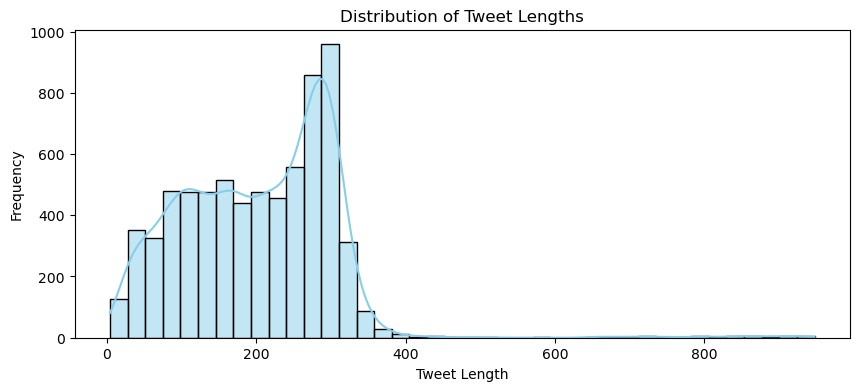

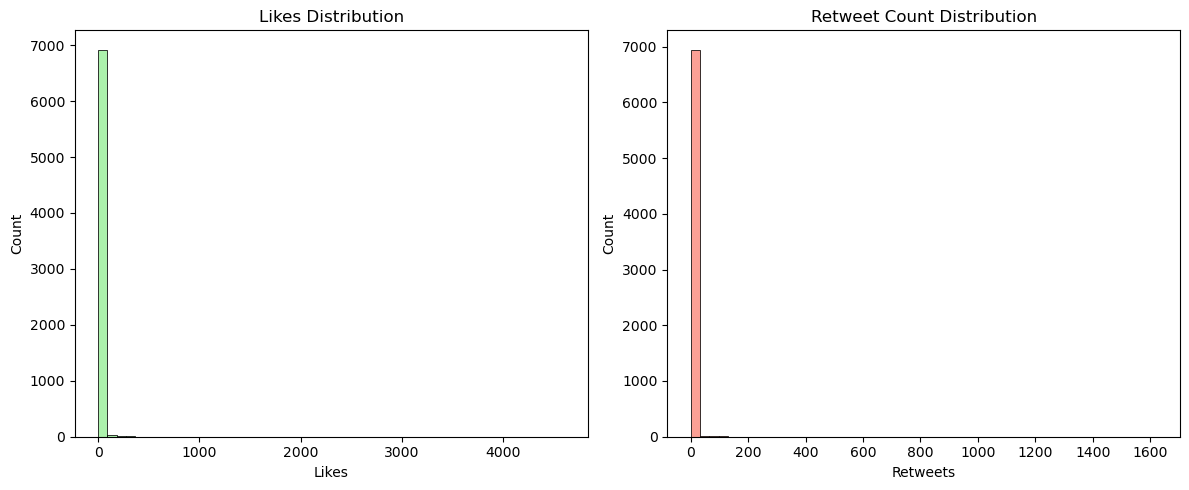

In [6]:
# ============================
#  Drop Duplicates
# ============================
duplicates = df.duplicated().sum()
print(f" Duplicate Rows: {duplicates}")
df.drop_duplicates(inplace=True)

# ============================
#  Add Tweet Length
# ============================
df['tweet_length'] = df['tweets'].apply(lambda x: len(str(x)))

# ============================
#  Length Distribution
# ============================
plt.figure(figsize=(10, 4))
sns.histplot(df['tweet_length'], bins=40, kde=True, color='skyblue')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

# ============================
#  Likes and Retweets
# ============================
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['likes'], bins=50, ax=axs[0], color='lightgreen')
axs[0].set_title("Likes Distribution")
axs[0].set_xlabel("Likes")

sns.histplot(df['retweet_count'], bins=50, ax=axs[1], color='salmon')
axs[1].set_title("Retweet Count Distribution")
axs[1].set_xlabel("Retweets")

plt.tight_layout()
plt.show()




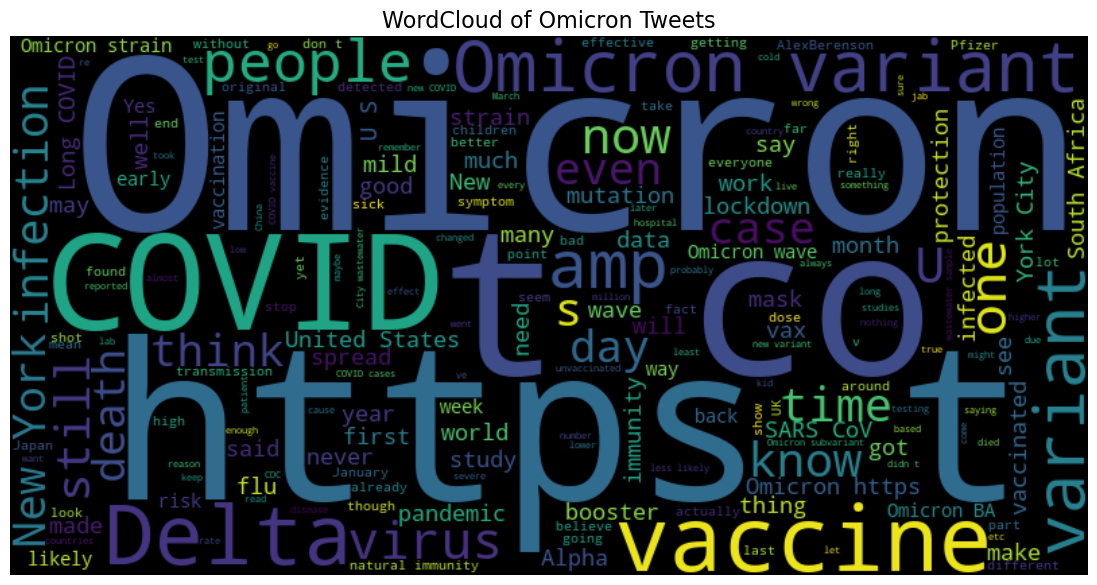

In [7]:
# ============================
# 🌥️ WordCloud (Basic Preview)
# ============================
all_text = " ".join(df['tweets'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='black',
                      stopwords=STOPWORDS).generate(all_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Omicron Tweets", fontsize=16)
plt.show()



In [8]:
# ============================
# 🧠 Top Frequent Words (NLTK)
# ============================
from collections import Counter

# Tokenize all tweets
tokens = []
for tweet in df['tweets']:
    tokens.extend(word_tokenize(str(tweet).lower()))

# Filter out stopwords and punctuation
filtered = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]

# Show top 15 frequent words
top_words = Counter(filtered).most_common(15)
print("🔝 Top 15 Frequent Words:\n")
for word, freq in top_words:
    print(f"{word}: {freq}")

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\brajagopal/nltk_data'
    - 'C:\\Users\\brajagopal\\anaconda3\\nltk_data'
    - 'C:\\Users\\brajagopal\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\brajagopal\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\brajagopal\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [9]:
import nltk
import os

# Set your NLTK data path explicitly
nltk_data_dir = r"C:\Users\brajagopal\AppData\Roaming\nltk_data"
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)

# Now safely download or use nltk modules
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\brajagopal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Tokenize all tweets using fixed path
tokens = []
for tweet in df['tweets']:
    tokens.extend(word_tokenize(str(tweet).lower()))

# Filter out stopwords and punctuation
filtered = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]

# Show top 15 frequent words
top_words = Counter(filtered).most_common(15)
print(" Top 15 Frequent Words:\n")
for word, freq in top_words:
    print(f"{word}: {freq}")


🔝 Top 15 Frequent Words:

omicron: 6509
https: 3267
covid: 1324
variant: 909
new: 868
delta: 756
people: 692
amp: 638
vaccine: 629
variants: 526
virus: 510
like: 468
us: 454
one: 438
get: 435


In [14]:
# Initialize NLP tools
tokenizer = ToktokTokenizer()
stopword_list = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()  # Or use LancasterStemmer()

# Full text cleaning pipeline
def clean_text(text, use_stem=False, use_lemma=True):
    # Ensure string
    text = str(text)

    # 1. Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Normalize unicode characters
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

    # 3. Lowercase
    text = text.lower()

    # 4. Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)

    # 5. Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # 6. Tokenize
    tokens = tokenizer.tokenize(text)

    # 7. Remove stopwords
    tokens = [t for t in tokens if t not in stopword_list]

    # 8. Apply stemming or lemmatization
    if use_stem:
        tokens = [stemmer.stem(t) for t in tokens]
    elif use_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # 9. Join tokens back into a single string
    return " ".join(tokens)

# Apply to entire dataset
df['cleaned_tweet'] = df['tweets'].apply(lambda x: clean_text(x))

# Show sample before and after
print("\n Raw Tweet:")
print(df['tweets'].iloc[0])

print("\n Cleaned Tweet:")
print(df['cleaned_tweet'].iloc[0])



🧪 Raw Tweet:
6 big questions about new Omicron-targeting boosters ... #Boosting #Target #targeting #boost https://t.co/9TWMuUXxJn

✅ Cleaned Tweet:
big question new omicrontargeting booster


In [15]:
# Function to get sentiment from TextBlob polarity
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment function
df['sentiment'] = df['cleaned_tweet'].apply(get_sentiment)

# Check sentiment distribution
print(" Sentiment Label Counts:")
print(df['sentiment'].value_counts())

# Preview sample labeled tweets
print("\n Sample Labeled Tweets:")
print(df[['cleaned_tweet', 'sentiment']].sample(5))


🔍 Sentiment Label Counts:
sentiment
Positive    3346
Neutral     1849
Negative    1803
Name: count, dtype: int64

🧾 Sample Labeled Tweets:
                                          cleaned_tweet sentiment
4122  already former accouuuntuh wish tribal skip om...   Neutral
3105  exactlyi remember sp epidemiologist dismissed ...  Negative
4443  grandpa omicron spread far wide swat progeny r...  Negative
2318  always wondered released subway huge operation...  Positive
2007  probably underestimated aspect pandemic persis...   Neutral


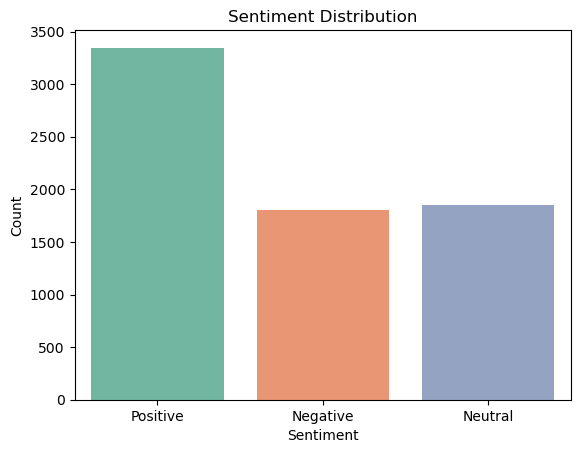

In [16]:
# Visualize sentiment distribution
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# Define input (X) and label (y)
X = df['cleaned_tweet']
y = df['sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y # keeps class distribution balanced
)

# Print size info
print(" Training Set Size:", X_train.shape[0])
print(" Testing Set Size:", X_test.shape[0])

# Check class distribution
print("\n Sentiment Distribution in Training Set:")
print(y_train.value_counts())

print("\n Sentiment Distribution in Test Set:")
print(y_test.value_counts())


✅ Training Set Size: 5598
✅ Testing Set Size: 1400

📊 Sentiment Distribution in Training Set:
sentiment
Positive    2677
Neutral     1479
Negative    1442
Name: count, dtype: int64

📊 Sentiment Distribution in Test Set:
sentiment
Positive    669
Neutral     370
Negative    361
Name: count, dtype: int64


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert set to list for sklearn compatibility
custom_stopwords = list(set(stopwords.words('english')).union(STOPWORDS))

# Initialize TF-IDF Vectorizer with fixed stopword list
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=custom_stopwords,
    ngram_range=(1, 2),
    min_df=2
)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)

# Display shape
print(" TF-IDF Train Shape:", X_train_tfidf.shape)
print(" TF-IDF Test Shape:", X_test_tfidf.shape)


✅ TF-IDF Train Shape: (5598, 5000)
✅ TF-IDF Test Shape: (1400, 5000)


In [21]:
print("Sample Vocabulary Features:")
print(vectorizer.get_feature_names_out()[:100])


📜 Sample Vocabulary Features:
['aa' 'ab' 'abc' 'abc news' 'ability' 'able' 'abnormality' 'absence'
 'absolute' 'absolutely' 'abt' 'abuse' 'accelerated' 'accept' 'access'
 'accident' 'accidental' 'accompanied' 'according' 'according abc'
 'according data' 'according latest' 'according state' 'account'
 'account nearly' 'accounted' 'accounted sequenced' 'accurate' 'ace'
 'ache' 'achieve' 'acknowledge' 'acknowledged' 'acquired' 'acquisition'
 'across' 'across alpha' 'across though' 'act' 'acting' 'action' 'active'
 'active case' 'active new' 'active tpr' 'activity' 'actual' 'actually'
 'acute' 'ad' 'adam' 'adaptation' 'adapted' 'adapted bivalent' 'add'
 'added' 'addition' 'additional' 'additional case' 'additional protection'
 'address' 'ade' 'administered' 'administration' 'admission' 'admit'
 'admitted' 'adolescent' 'adult' 'adult delta' 'adult infected'
 'adult younger' 'advance' 'advanced' 'advantage' 'advent' 'adverse'
 'advice' 'advisor' 'advocate' 'aerosol' 'affect' 'affect united'

In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print(f"\n Model: {model.__class__.__name__}")
    print(" Accuracy:", accuracy_score(y_test, y_pred))
    print("\n Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Negative', 'Neutral'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Positive', 'Negative', 'Neutral'], 
                yticklabels=['Positive', 'Negative', 'Neutral'])
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



🧪 Model: LogisticRegression
🔹 Accuracy: 0.7607142857142857

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.52      0.64       361
     Neutral       0.78      0.75      0.76       370
    Positive       0.74      0.90      0.81       669

    accuracy                           0.76      1400
   macro avg       0.78      0.72      0.74      1400
weighted avg       0.77      0.76      0.75      1400



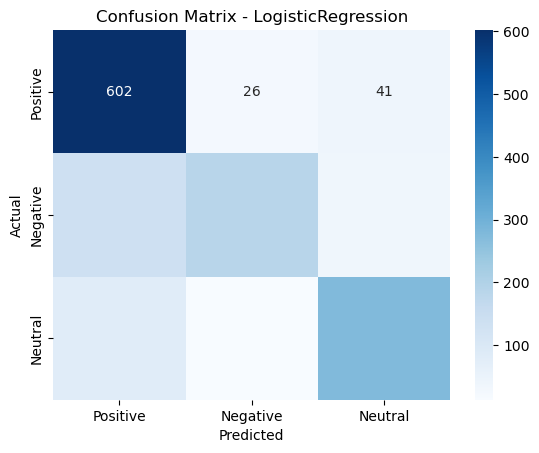

In [23]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, y_train)
evaluate_model(lr_model, X_test_tfidf, y_test)



🧪 Model: MultinomialNB
🔹 Accuracy: 0.6321428571428571

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.37      0.51       361
     Neutral       0.85      0.32      0.46       370
    Positive       0.58      0.95      0.72       669

    accuracy                           0.63      1400
   macro avg       0.75      0.54      0.56      1400
weighted avg       0.71      0.63      0.60      1400



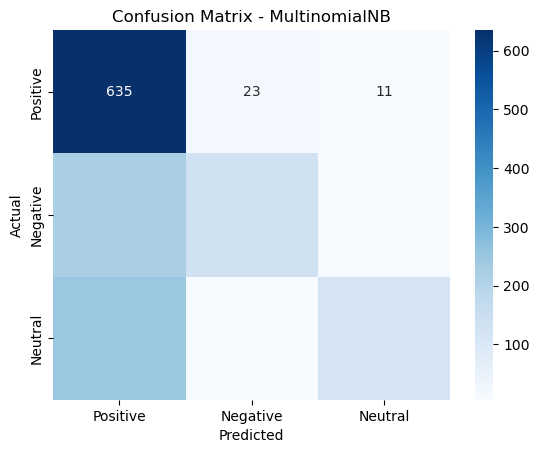

In [24]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_model(nb_model, X_test_tfidf, y_test)



🧪 Model: SGDClassifier
🔹 Accuracy: 0.7957142857142857

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.65      0.70       361
     Neutral       0.78      0.81      0.80       370
    Positive       0.81      0.87      0.84       669

    accuracy                           0.80      1400
   macro avg       0.79      0.78      0.78      1400
weighted avg       0.79      0.80      0.79      1400



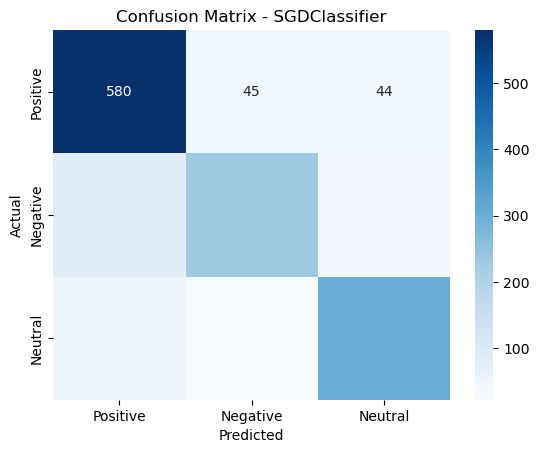

In [25]:
sgd_model = SGDClassifier(loss='hinge', random_state=42)
sgd_model.fit(X_train_tfidf, y_train)
evaluate_model(sgd_model, X_test_tfidf, y_test)



🧪 Model: SVC
🔹 Accuracy: 0.7892857142857143

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.60      0.69       361
     Neutral       0.77      0.81      0.79       370
    Positive       0.79      0.88      0.83       669

    accuracy                           0.79      1400
   macro avg       0.79      0.76      0.77      1400
weighted avg       0.79      0.79      0.78      1400



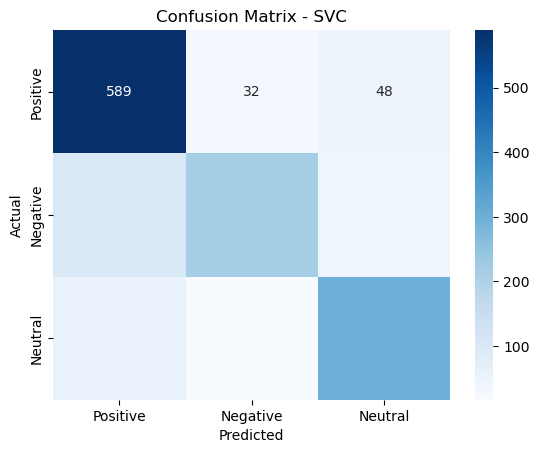

In [26]:
svc_model = SVC(kernel='linear')
svc_model.fit(X_train_tfidf, y_train)
evaluate_model(svc_model, X_test_tfidf, y_test)


🔍 Best Params (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

🧪 Model: LogisticRegression
🔹 Accuracy: 0.8028571428571428

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.66      0.71       361
     Neutral       0.79      0.81      0.80       370
    Positive       0.82      0.88      0.85       669

    accuracy                           0.80      1400
   macro avg       0.80      0.78      0.79      1400
weighted avg       0.80      0.80      0.80      1400



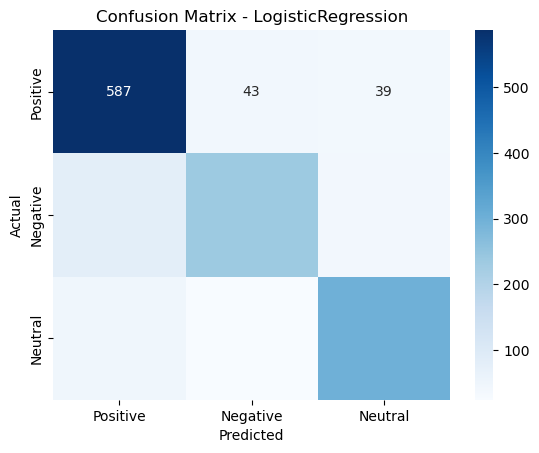

In [27]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize GridSearch
grid_lr = GridSearchCV(LogisticRegression(max_iter=300), param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train_tfidf, y_train)

# Best Parameters
print(" Best Params (Logistic Regression):", grid_lr.best_params_)

# Evaluate best model
evaluate_model(grid_lr.best_estimator_, X_test_tfidf, y_test)


🔍 Best Params (SGDClassifier): {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l1'}

🧪 Model: SGDClassifier
🔹 Accuracy: 0.8528571428571429

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      0.70      0.78       361
     Neutral       0.81      0.95      0.87       370
    Positive       0.87      0.88      0.88       669

    accuracy                           0.85      1400
   macro avg       0.85      0.84      0.84      1400
weighted avg       0.86      0.85      0.85      1400



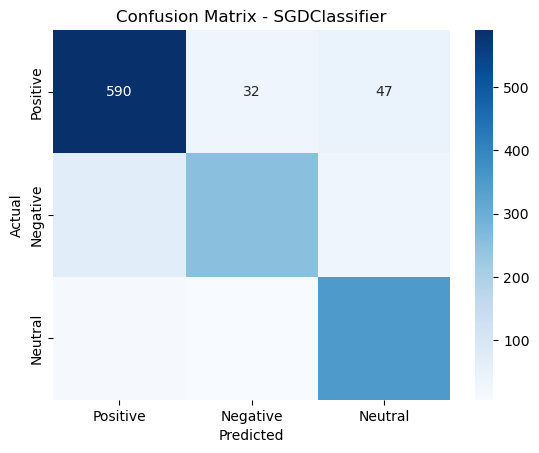

In [28]:
param_grid_sgd = {
    'loss': ['hinge', 'log_loss'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'penalty': ['l2', 'l1'],
    'max_iter': [1000, 2000]
}

grid_sgd = GridSearchCV(SGDClassifier(random_state=42), param_grid_sgd, cv=5, n_jobs=-1, scoring='accuracy')
grid_sgd.fit(X_train_tfidf, y_train)

print(" Best Params (SGDClassifier):", grid_sgd.best_params_)
evaluate_model(grid_sgd.best_estimator_, X_test_tfidf, y_test)


🔍 Best Params (Naive Bayes): {'alpha': 0.1}

🧪 Model: MultinomialNB
🔹 Accuracy: 0.6735714285714286

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.54      0.60       361
     Neutral       0.80      0.46      0.58       370
    Positive       0.64      0.87      0.74       669

    accuracy                           0.67      1400
   macro avg       0.71      0.62      0.64      1400
weighted avg       0.69      0.67      0.66      1400



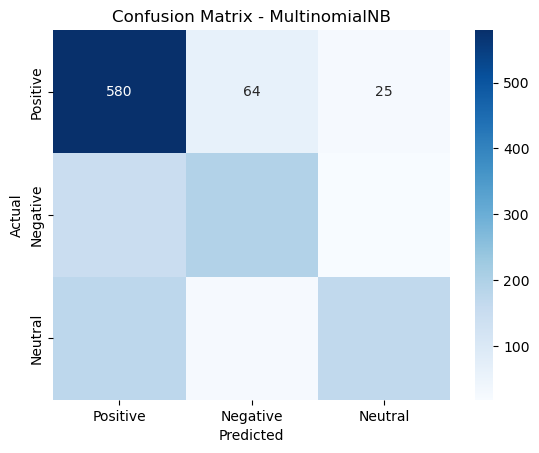

In [29]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(X_train_tfidf, y_train)

print("🔍 Best Params (Naive Bayes):", grid_nb.best_params_)
evaluate_model(grid_nb.best_estimator_, X_test_tfidf, y_test)


🔍 Best Params (SVM): {'C': 1, 'kernel': 'linear'}

🧪 Model: SVC
🔹 Accuracy: 0.7892857142857143

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.60      0.69       361
     Neutral       0.77      0.81      0.79       370
    Positive       0.79      0.88      0.83       669

    accuracy                           0.79      1400
   macro avg       0.79      0.76      0.77      1400
weighted avg       0.79      0.79      0.78      1400



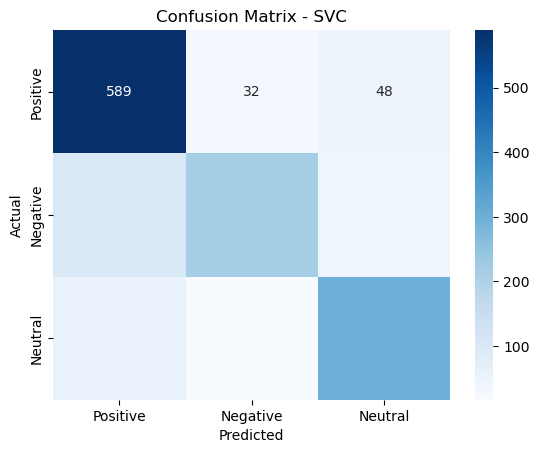

In [30]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']  # for text data, linear works best
}

grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train_tfidf, y_train)

print("🔍 Best Params (SVM):", grid_svc.best_params_)
evaluate_model(grid_svc.best_estimator_, X_test_tfidf, y_test)


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


✅ Best Params (Logistic Regression): {'clf__C': 10, 'clf__solver': 'lbfgs'}

🧪 Model: Pipeline
🔹 Accuracy: 0.8071428571428572

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.65      0.71       361
     Neutral       0.81      0.82      0.82       370
    Positive       0.81      0.88      0.85       669

    accuracy                           0.81      1400
   macro avg       0.80      0.79      0.79      1400
weighted avg       0.81      0.81      0.80      1400



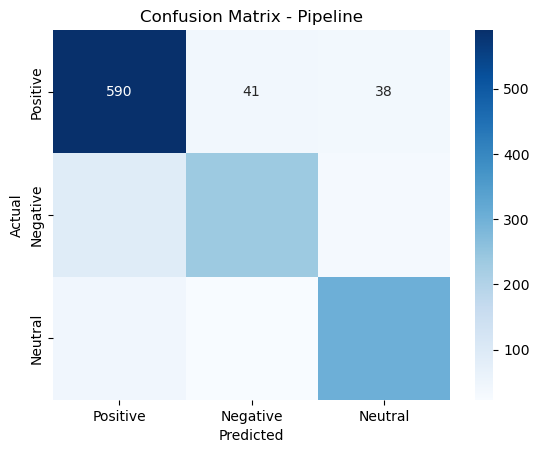

In [32]:
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords, max_features=5000)),
    ('clf', LogisticRegression(max_iter=300))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("✅ Best Params (Logistic Regression):", grid_lr.best_params_)
evaluate_model(grid_lr.best_estimator_, X_test, y_test)


✅ Best Params (SGDClassifier): {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l1'}

🧪 Model: Pipeline
🔹 Accuracy: 0.865

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.74      0.80       361
     Neutral       0.84      0.94      0.88       370
    Positive       0.88      0.89      0.89       669

    accuracy                           0.86      1400
   macro avg       0.86      0.86      0.86      1400
weighted avg       0.87      0.86      0.86      1400



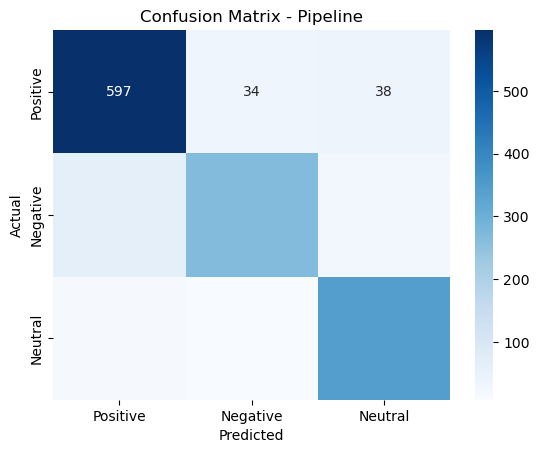

In [33]:
pipe_sgd = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords, max_features=5000)),
    ('clf', SGDClassifier(random_state=42))
])

param_grid_sgd = {
    'clf__loss': ['hinge', 'log_loss'],
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l2', 'l1']
}

grid_sgd = GridSearchCV(pipe_sgd, param_grid_sgd, cv=5, n_jobs=-1, scoring='accuracy')
grid_sgd.fit(X_train, y_train)

print("✅ Best Params (SGDClassifier):", grid_sgd.best_params_)
evaluate_model(grid_sgd.best_estimator_, X_test, y_test)


✅ Best Params (Naive Bayes): {'clf__alpha': 0.1}

🧪 Model: Pipeline
🔹 Accuracy: 0.6735714285714286

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.50      0.58       361
     Neutral       0.84      0.43      0.57       370
    Positive       0.63      0.90      0.75       669

    accuracy                           0.67      1400
   macro avg       0.72      0.61      0.63      1400
weighted avg       0.70      0.67      0.66      1400



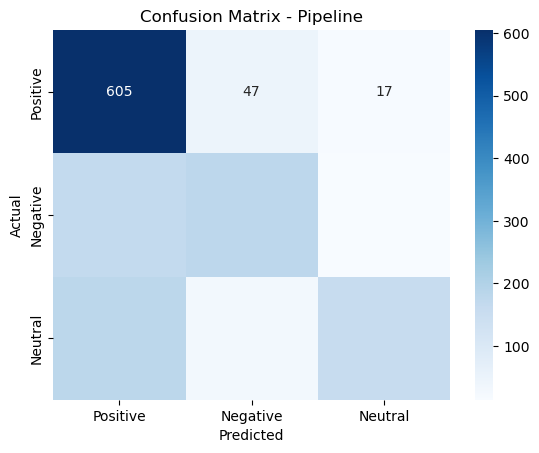

In [34]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords, max_features=5000)),
    ('clf', MultinomialNB())
])

param_grid_nb = {
    'clf__alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, scoring='accuracy')
grid_nb.fit(X_train, y_train)

print("✅ Best Params (Naive Bayes):", grid_nb.best_params_)
evaluate_model(grid_nb.best_estimator_, X_test, y_test)


✅ Best Params (SVM): {'clf__C': 10, 'clf__kernel': 'linear'}

🧪 Model: Pipeline
🔹 Accuracy: 0.8071428571428572

🔹 Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.69      0.71       361
     Neutral       0.81      0.83      0.82       370
    Positive       0.85      0.86      0.85       669

    accuracy                           0.81      1400
   macro avg       0.79      0.79      0.79      1400
weighted avg       0.81      0.81      0.81      1400



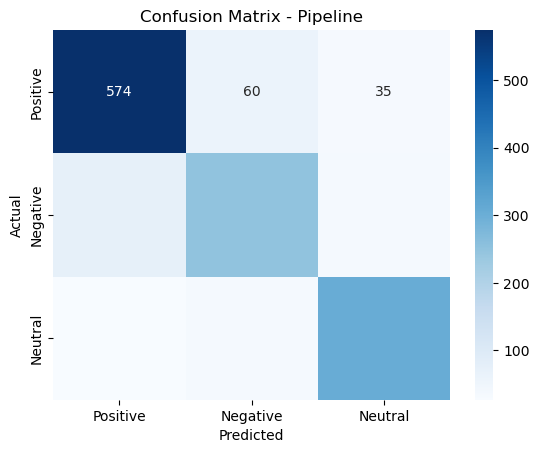

In [35]:
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords, max_features=5000)),
    ('clf', SVC())
])

param_grid_svc = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear']
}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)

print("✅ Best Params (SVM):", grid_svc.best_params_)
evaluate_model(grid_svc.best_estimator_, X_test, y_test)


In [51]:
# Reuse the same clean_text() function from Part 4

def predict_sentiment(text, model=grid_lr.best_estimator_):
    cleaned = clean_text(text)
    prediction = model.predict([cleaned])[0]
    print(f"\n🔍 Tweet: {text}")
    print(f"🧠 Cleaned: {cleaned}")
    print(f"💬 Predicted Sentiment: {prediction}")

# Example Usage
sample_tweet_1 = "New Omicron cases rising rapidly. Stay safe everyone!"
sample_tweet_2 = "Vaccines are working well against new variants!"
sample_tweet_3 = "Omicron situation seems to be improving across countries."

predict_sentiment(sample_tweet_1)
predict_sentiment(sample_tweet_2)
predict_sentiment(sample_tweet_3)



🔍 Tweet: New Omicron cases rising rapidly. Stay safe everyone!
🧠 Cleaned: new omicron case rising rapidly stay safe everyone
💬 Predicted Sentiment: Positive

🔍 Tweet: Vaccines are working well against new variants!
🧠 Cleaned: vaccine working well new variant
💬 Predicted Sentiment: Positive

🔍 Tweet: Omicron situation seems to be improving across countries.
🧠 Cleaned: omicron situation seems improving across country
💬 Predicted Sentiment: Neutral


In [52]:
# Store accuracy once
model = grid_lr.best_estimator_

# Evaluate once (for display)
test_accuracy = model.score(X_test, y_test)
print(f"\n📈 Model Accuracy on Test Set: {test_accuracy:.2%}")

# Prediction function
def predict_sentiment(text, model=model):
    cleaned = clean_text(text)
    prediction = model.predict([cleaned])[0]
    print(f"\n🔍 Tweet: {text}")
    print(f"🧠 Cleaned: {cleaned}")
    print(f"💬 Predicted Sentiment: {prediction}")

# Example Usage
sample_tweet_1 = "New Omicron cases rising rapidly. Stay safe everyone!"
sample_tweet_2 = "Omicron situation seems to be improving across countries"
sample_tweet_3 = "I don’t care about this news anymore."

predict_sentiment(sample_tweet_1)
predict_sentiment(sample_tweet_2)
predict_sentiment(sample_tweet_3)



📈 Model Accuracy on Test Set: 80.71%

🔍 Tweet: New Omicron cases rising rapidly. Stay safe everyone!
🧠 Cleaned: new omicron case rising rapidly stay safe everyone
💬 Predicted Sentiment: Positive

🔍 Tweet: Omicron situation seems to be improving across countries
🧠 Cleaned: omicron situation seems improving across country
💬 Predicted Sentiment: Neutral

🔍 Tweet: I don’t care about this news anymore.
🧠 Cleaned: dont care news anymore
💬 Predicted Sentiment: Neutral


In [40]:
def predict_sentiment_proba(text, model=model):
    cleaned = clean_text(text)
    prediction = model.predict([cleaned])[0]
    probabilities = model.predict_proba([cleaned])[0]
    
    print(f"\n🔍 Tweet: {text}")
    print(f"🧠 Cleaned: {cleaned}")
    print(f"💬 Predicted Sentiment: {prediction}")
    
    print("\n📊 Class Probabilities:")
    for cls, prob in zip(model.classes_, probabilities):
        print(f"{cls}: {prob:.2%}")

In [41]:
# Set best SGD model
model = grid_sgd.best_estimator_

# Evaluate once
test_accuracy = model.score(X_test, y_test)
print(f"\n📈 SGDClassifier Accuracy on Test Set: {test_accuracy:.2%}")

# Prediction function
def predict_sentiment(text, model=model):
    cleaned = clean_text(text)
    prediction = model.predict([cleaned])[0]
    print(f"\n🔍 Tweet: {text}")
    print(f"🧠 Cleaned: {cleaned}")
    print(f"💬 Predicted Sentiment: {prediction}")

# Example Usage
sample_tweet_1 = "Omicron is now the dominant variant in most regions."
sample_tweet_2 = "Finally some good news about the pandemic!"
sample_tweet_3 = "This whole COVID thing is getting boring."

predict_sentiment(sample_tweet_1)
predict_sentiment(sample_tweet_2)
predict_sentiment(sample_tweet_3)



📈 SGDClassifier Accuracy on Test Set: 86.50%

🔍 Tweet: Omicron is now the dominant variant in most regions.
🧠 Cleaned: omicron dominant variant region
💬 Predicted Sentiment: Neutral

🔍 Tweet: Finally some good news about the pandemic!
🧠 Cleaned: finally good news pandemic
💬 Predicted Sentiment: Positive

🔍 Tweet: This whole COVID thing is getting boring.
🧠 Cleaned: whole covid thing getting boring
💬 Predicted Sentiment: Positive


In [47]:
param_grid_sgd = {
    'clf__loss': ['log_loss'],  # This is essential
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l2', 'l1']
}


In [48]:
grid_sgd = GridSearchCV(pipe_sgd, param_grid_sgd, cv=5, n_jobs=-1, scoring='accuracy')
grid_sgd.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        stop_words=['o', 'that',
                                                                    'm', 'we',
                                                                    'they',
                                                                    'doing',
                                                                    'up',
                                                                    "we're",
                                                                    'each',
                                                                    "wouldn't",
                                                                    "we've",
                                                                    'if',
                                                                    'wouldn',
                                                                    're',
                                                                    'could',
                                                                    'here',
                                                                    'most',
                                                                    "won't",
                                                                    'do',
                                                                    'both', 'y',
                                                                    "he'll",
                                                                    'does',
                                                                    'through',
                                                                    "mightn't",
                                                                    'on',
                                                                    'like',
                                                                    "he'd",
                                                                    "they'd",
                                                                    'few', ...])),
                                       ('clf',
                                        SGDClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                         'clf__loss': ['log_loss'],
                         'clf__penalty': ['l2', 'l1']},
             scoring='accuracy')

In [49]:
# Get best SGD model
model = grid_sgd.best_estimator_

# Evaluate model once
test_accuracy = model.score(X_test, y_test)
print(f"\n📈 SGDClassifier Accuracy on Test Set: {test_accuracy:.2%}")

# Function to predict with probability
def predict_sentiment_proba(text, model=model):
    cleaned = clean_text(text)
    prediction = model.predict([cleaned])[0]
    probabilities = model.predict_proba([cleaned])[0]
    
    print(f"\n🔍 Tweet: {text}")
    print(f"🧠 Cleaned: {cleaned}")
    print(f"💬 Predicted Sentiment: {prediction}")
    
    print("\n📊 Confidence Scores:")
    for label, prob in zip(model.classes_, probabilities):
        print(f"   {label}: {prob:.2%}")



📈 SGDClassifier Accuracy on Test Set: 83.71%


In [50]:
sample_tweet = "Omicron situation seems to be improving across countries."
predict_sentiment_proba(sample_tweet)



🔍 Tweet: Omicron situation seems to be improving across countries.
🧠 Cleaned: omicron situation seems improving across country
💬 Predicted Sentiment: Neutral

📊 Confidence Scores:
   Negative: 9.91%
   Neutral: 65.78%
   Positive: 24.30%


In [53]:

sample_tweet = "The new Spider-Man movie was amazing!"
predict_sentiment_proba(sample_tweet)



🔍 Tweet: The new Spider-Man movie was amazing!
🧠 Cleaned: new spiderman movie amazing
💬 Predicted Sentiment: Positive

📊 Confidence Scores:
   Negative: 6.31%
   Neutral: 0.18%
   Positive: 93.50%


In [ ]:
sample_tweet = "The new Spider-Man movie was amazing!"
predict_sentiment_proba(sample_tweet)


In [54]:
sample_tweet = "My team won the World Cup!"
predict_sentiment_proba(sample_tweet)



🔍 Tweet: My team won the World Cup!
🧠 Cleaned: team world cup
💬 Predicted Sentiment: Neutral

📊 Confidence Scores:
   Negative: 17.07%
   Neutral: 59.27%
   Positive: 23.66%


In [58]:
sample_tweet = "i am sad"
predict_sentiment_proba(sample_tweet)


🔍 Tweet: i am sad
🧠 Cleaned: sad
💬 Predicted Sentiment: Negative

📊 Confidence Scores:
   Negative: 77.70%
   Neutral: 21.54%
   Positive: 0.76%


In [59]:
sample_tweet = "AI is the future of technology"
predict_sentiment_proba(sample_tweet)


🔍 Tweet: AI is the future of technology
🧠 Cleaned: ai future technology
💬 Predicted Sentiment: Neutral

📊 Confidence Scores:
   Negative: 15.96%
   Neutral: 54.93%
   Positive: 29.10%
